# DenseNet on Eye Dataset

In [ ]:
! pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Libraries

In [ ]:
import opendatasets as od
import PIL
import glob
import numpy as np
import sklearn
import tensorflow as tf
from tensorflow import keras
import os
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import pandas as pd
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, AveragePooling2D, GlobalAveragePooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def mount_drive(fr = False):
    from google.colab import drive
    drive.mount("/content/drive/", force_remount = fr)

# Loading Data

In [ ]:
def fetch_eyes():

    mount_drive(False)
    
    # Choose your image size
    # AlexNet
    IMAGE_SIZE = (224, 224)
    
    output = []

    class_names = ['Open', 'Closed', 'no_yawn', 'yawn']
    index  = [0, 1, 2, 3]

    # Build a dictionary that maps the category to an index/integer

    class_names_label = dict(list((zip(class_names, index))))

    # Iterate through training and test sets
    def function1(dataset):
      
        images = []
        labels = []

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in our folder
            for file in os.listdir(os.path.join(dataset, folder)):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # This function specifically is what resizes, IMAGE_SIZE is defined above
                image = cv2.resize(image, IMAGE_SIZE) 

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   

        # Shuffling
        images, labels = sklearn.utils.shuffle(images, labels)

        # Normalizing data
        images = images / 255.0 

        # One- hot Encoding
        labels = pd.get_dummies(pd.Series(labels)).to_numpy()

        return images, labels

    (image_train, label_train), (image_test, label_test) =  function1('/content/drive/MyDrive/Colab Notebooks/DATA4380-project/yawn-eye-dataset-new/dataset_new/train'), function1('/content/drive/MyDrive/Colab Notebooks/DATA4380-project/yawn-eye-dataset-new/dataset_new/test')

    return image_train, label_train, image_test, label_test


In [ ]:
image_train, label_train, image_test, label_test = fetch_eyes()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
label_train

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0]], dtype=uint8)

In [ ]:
image_train

array([[[[0.5882353 , 0.6117647 , 0.6745098 ],
         [0.5882353 , 0.6117647 , 0.6745098 ],
         [0.56078434, 0.58431375, 0.64705884],
         ...,
         [0.3882353 , 0.3019608 , 0.3529412 ],
         [0.38431373, 0.29803923, 0.34901962],
         [0.38039216, 0.29411766, 0.34509805]],

        [[0.64705884, 0.6666667 , 0.73333335],
         [0.627451  , 0.6509804 , 0.7137255 ],
         [0.5764706 , 0.59607846, 0.6627451 ],
         ...,
         [0.38431373, 0.29803923, 0.34901962],
         [0.38431373, 0.29803923, 0.34901962],
         [0.38039216, 0.29411766, 0.34509805]],

        [[0.6901961 , 0.7137255 , 0.7764706 ],
         [0.6627451 , 0.6862745 , 0.7490196 ],
         [0.60784316, 0.6313726 , 0.69411767],
         ...,
         [0.3882353 , 0.3019608 , 0.3529412 ],
         [0.38431373, 0.29803923, 0.34901962],
         [0.38431373, 0.29803923, 0.34901962]],

        ...,

        [[0.72156864, 0.7411765 , 0.8156863 ],
         [0.7137255 , 0.73333335, 0.80784315]

# Model_Setup

In [ ]:
def dense121(IMAGE_SIZE):
    # Define input layer
    inputs = tf.keras.Input(shape=IMAGE_SIZE)
    
    # Preprocessing layers
    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=3, strides=2, padding='same')(x)
    
    # DenseBlock 1
    x = dense_block(x, 6, 32)
    # Transition Layer 1
    x = transition_layer(x, 128)
    
    # DenseBlock 2
    x = dense_block(x, 6, 32) # increase growth rate
    # Transition Layer 2
    x = transition_layer(x, 228)
    
    # DenseBlock 3
    x = dense_block(x, 12, 128) # increase growth rate
    # Transition Layer 3
    x = transition_layer(x, 478)
    
    # DenseBlock 4
    x = dense_block(x, 16, 128) # increase growth rate
    
    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)
    
    # Output layer
    outputs = Dense(4, activation='softmax')(x)
    
    # Build the model
    model = Model(inputs, outputs, name='densenet121')
    
    return model
def conv_block(x, growth_rate):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(growth_rate, 3, padding='same')(x)
    return x

def dense_block(x, layers, growth_rate):
    for i in range(layers):
        conv = conv_block(x, growth_rate)
        x = concatenate([x, conv])
    return x

def transition_layer(x, filters):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 1)(x)
    x = AveragePooling2D(2, strides=2)(x)
    return x





In [ ]:
model_1 = dense121(IMAGE_SIZE=(224, 224, 3))
model_1.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                       

In [ ]:
model_1.compile(optimizer= Adam(lr= 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
image_train_1, label_train_1, image_test_1, label_test_1 = fetch_eyes()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
image_train_1.shape

(2467, 224, 224, 3)

# Training

In [ ]:
#20 x 64 = 1280 images being trained per epoch
history = model_1.fit(x=image_train_1, y=label_train_1, validation_data=(image_test_1, label_test_1),
                      steps_per_epoch=20, 
                      validation_steps=3,
                      shuffle=2, 
                      verbose=1, 
                      epochs=30, 
                      batch_size=64)


Epoch 1/30
20/20 [==============================] - 69s 683ms/step - loss: 15.7420 - accuracy: 0.3844 - val_loss: 415464.5938 - val_accuracy: 0.2396
Epoch 2/30
20/20 [==============================] - 24s 1s/step - loss: 2.5608 - accuracy: 0.4900 - val_loss: 2628.8179 - val_accuracy: 0.2604
Epoch 3/30
20/20 [==============================] - 13s 647ms/step - loss: 2.5171 - accuracy: 0.5016 - val_loss: 105.3291 - val_accuracy: 0.2448
Epoch 4/30
20/20 [==============================] - 13s 652ms/step - loss: 2.9500 - accuracy: 0.5108 - val_loss: 14.6418 - val_accuracy: 0.4427
Epoch 5/30
20/20 [==============================] - 14s 679ms/step - loss: 2.5809 - accuracy: 0.4938 - val_loss: 66.9923 - val_accuracy: 0.1771
Epoch 6/30
20/20 [==============================] - 13s 660ms/step - loss: 1.8735 - accuracy: 0.5292 - val_loss: 2.2836 - val_accuracy: 0.3854
Epoch 7/30
20/20 [==============================] - 13s 657ms/step - loss: 3.1802 - accuracy: 0.5102 - val_loss: 4166.0483 - val_acc

# Classification Report

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
from tabulate import tabulate
import pandas as pd


# Assuming your test data is stored in numpy arrays called `imagetest` and `labeltest`
batch_size = 64
test_ds = tf.data.Dataset.from_tensor_slices((image_test_1, label_test_1)).batch(batch_size)

# Generate predictions for the test dataset
test_predictions = model_1.predict(test_ds)
test_predictions_classes = np.argmax(test_predictions, axis=-1)

# Compute classification report and print results
report = classification_report(label_test_1.argmax(axis=1), test_predictions_classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(tabulate(df_report, headers='keys', tablefmt='psql'))


7/7 [==============================] - 8s 1s/step
+--------------+-------------+----------+------------+------------+
|              |   precision |   recall |   f1-score |    support |
|--------------+-------------+----------+------------+------------|
| 0            |    0.896552 | 0.954128 |   0.924444 | 109        |
| 1            |    0.969697 | 0.880734 |   0.923077 | 109        |
| 2            |    0.635417 | 0.559633 |   0.595122 | 109        |
| 3            |    0.590164 | 0.679245 |   0.631579 | 106        |
| accuracy     |    0.769053 | 0.769053 |   0.769053 |   0.769053 |
| macro avg    |    0.772957 | 0.768435 |   0.768556 | 433        |
| weighted avg |    0.774224 | 0.769053 |   0.769505 | 433        |
+--------------+-------------+----------+------------+------------+


# Training Curve

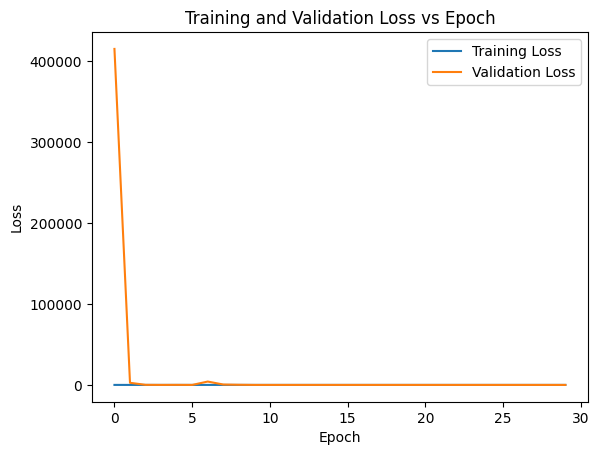

In [ ]:
import matplotlib.pyplot as plt

# plot training loss
plt.plot(history.history['loss'], label='Training Loss')

# plot validation loss
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


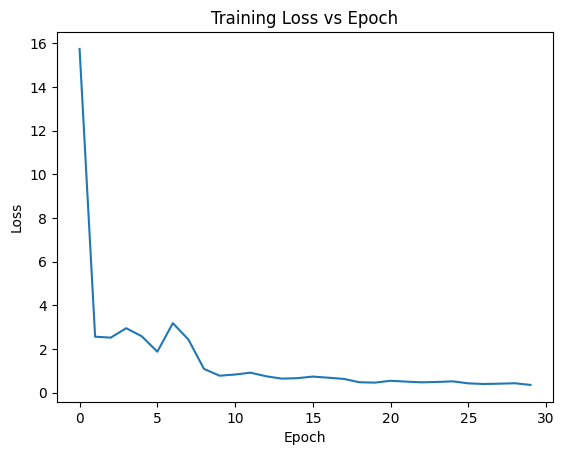

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Training Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()



# Evaluations

In [ ]:
scores2 = model_1.evaluate(image_test_1, label_test_1)
print(scores2)

14/14 [==============================] - 9s 335ms/step - loss: 0.4363 - accuracy: 0.7691
[0.43632930517196655, 0.7690531015396118]


In [ ]:
y_pred2 = model_1.predict(image_test_1)

14/14 [==============================] - 2s 101ms/step


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

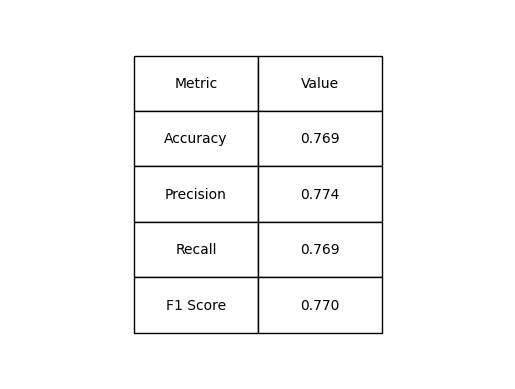

In [ ]:
y_pred_classes = np.argmax(y_pred2, axis=1)
label_test_classes = np.argmax(label_test_1, axis=1)

accuracy2 = scores2[1]
type(accuracy2)

precision2 = precision_score(label_test_classes, y_pred_classes, average='weighted')
f12 = f1_score(label_test_classes, y_pred_classes, average='weighted')
recall2 = recall_score(label_test_classes, y_pred_classes, average='weighted')

headers2 = ["Metric", "Value"]
data2 = [
    
    ["Accuracy", "%.3f" % accuracy2],
    ["Precision", "%.3f" % precision2],
    ["Recall", "%.3f" % recall2],
    ["F1 Score", "%.3f" % f12],
]

fig2, ax2 = plt.subplots()
ax2.axis('tight')
ax2.axis('off')
table2 = ax2.table(cellText=data2, colLabels=headers2, cellLoc='center', loc='center')

# Auto-size the columns
for key, cell in table2.get_celld().items():
    cell.set_width(0.25)
    cell.set_height(0.15)

# Save the table as a PNG image
plt.savefig('metrics_table.png', bbox_inches='tight', dpi=300)

# Show the table in the notebook (optional)
plt.show()